In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import pickle
import io

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from sklearn import cluster, metrics, model_selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from scipy.special import rel_entr
from scipy.spatial import distance_matrix
from plotly.subplots import make_subplots
from PIL import Image

plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

# Probabilistic PCA from a GitHub fork (Ludvig Hult) 
# ! pip install git+https://github.com/el-hult/pyppca
from pyppca import ppca

In [2]:
bzcat = pd.read_csv('data/BZCAT_all_features.csv')  # Catalog, all features 
model_df = bzcat.copy()  # model dataframe
model_df.head(3)

,BZCAT5 Source name,RA (J2000.0),Dec (J2000.0),Redshift,Class,Rad_opt_sp_index,alpha_1.1-2.3,alpha_2.3-4.8,alpha_4.8-7.7,alpha_4.8-11.2,...,IR_opt,IR_UV,IR_X,IR_gamma,opt_UV,opt_X,opt_gamma,UV_X,UV_gamma,X_gamma
0,5BZQJ0000-3221,00 00 20.39,-32 21 01.0,1.275,BZQ,0.707,NaN,0.056,-0.763,NaN,...,NaN,-0.434905,0.966619,NaN,NaN,NaN,NaN,1.401524,NaN,NaN
1,5BZQJ0001-1551,00 01 05.29,-15 51 06.98,2.044,BZQ,0.661,NaN,-0.281,-0.599,-0.788,...,-0.40052,-0.189982,NaN,NaN,0.210538,NaN,NaN,NaN,NaN,NaN
2,5BZQJ0001+1914,00 01 08.62,+19 14 34.18,3.100,BZQ,0.917,-0.117,0.029,0.276,-0.427,...,0.18340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
bzcat[['log_nuF_gamma']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3561 entries, 0 to 3560
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   log_nuF_gamma  1556 non-null   float64
dtypes: float64(1)
memory usage: 27.9 KB


## 1. Cleansing

Missing values heatmap

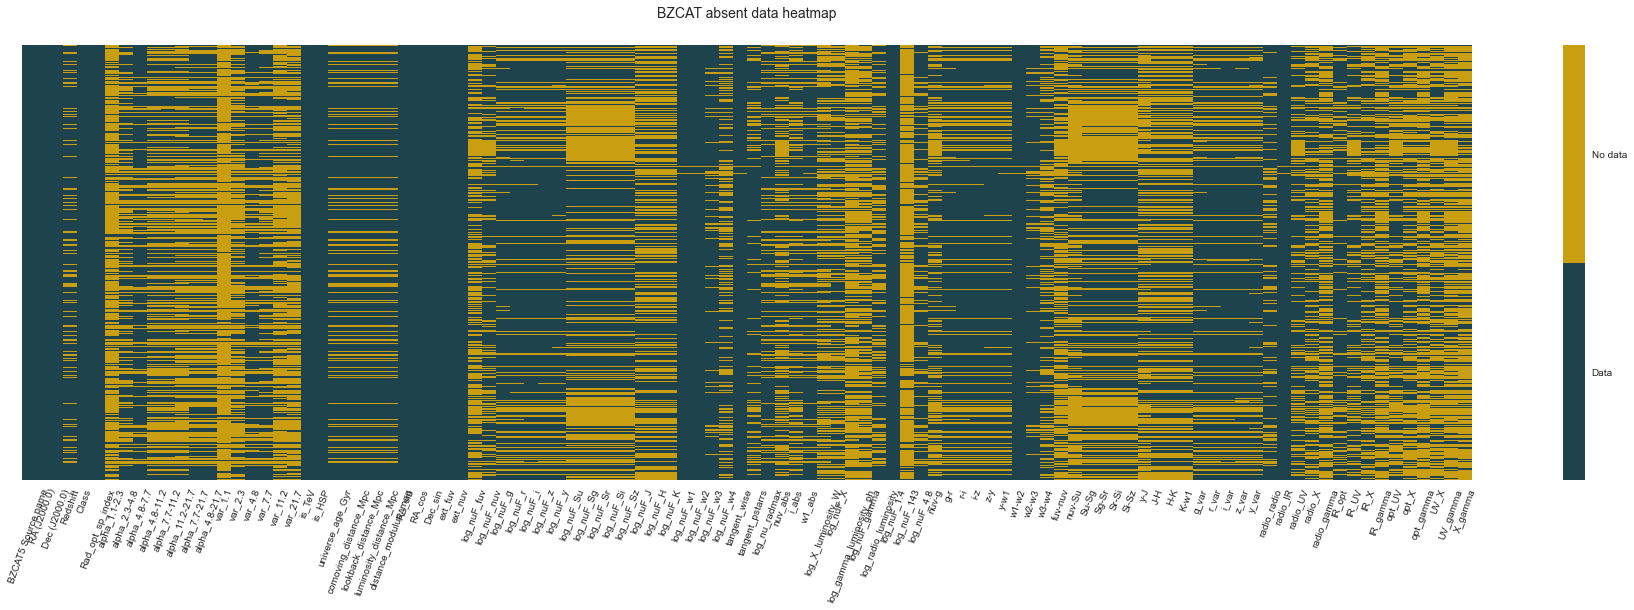

In [4]:
colors = ['#1e434c', '#c99e10'] 
fig = plt.figure(figsize=(32.5, 8))
ax = sns.heatmap(
    model_df.isnull(),  
    cmap=sns.color_palette(colors),
    yticklabels=False
)

colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0.25, 0.75])
colorbar.set_ticklabels(['Data', 'No data'])

plt.xticks(rotation=70)
ax.set_title('BZCAT absent data heatmap', y=1.05, fontsize = 14);

The fraction of missing values in some columns

In [5]:
model_df.iloc[:,60:80].isnull().mean()

log_nuF_gamma           0.563044
log_radio_luminosity    0.328559
log_nuF_1.4             0.003089
log_nuF_143             0.844145
log_nuF_4.8             0.185622
nuv-g                   0.412244
g-r                     0.197136
r-i                     0.188430
i-z                     0.185622
z-y                     0.194047
y-w1                    0.200786
w1-w2                   0.015445
w2-w3                   0.085088
w3-w4                   0.291210
fuv-nuv                 0.590845
nuv-Su                  0.576804
Su-Sg                   0.455490
Sg-Sr                   0.455490
Sr-Si                   0.455490
Si-Sz                   0.455490
dtype: float64

Dropping rows without gamma flux

Dropping columns with many missing values

In [6]:
cols_to_drop = model_df.isnull().mean() > 0.4  
cols_to_drop = cols_to_drop[cols_to_drop].index

model_df.drop(columns=cols_to_drop, inplace=True)

Returning gamma-ray features

In [7]:
model_df['log_nuF_gamma'] = bzcat['log_nuF_gamma']
model_df['log_gamma_luminosity_ph'] = bzcat['log_gamma_luminosity_ph']
model_df['radio_gamma'] = bzcat['radio_gamma']
model_df['IR_gamma'] = bzcat['IR_gamma']
model_df['opt_gamma'] = bzcat['opt_gamma']
model_df['UV_gamma'] = bzcat['UV_gamma']
model_df['X_gamma'] = bzcat['X_gamma']

1. Deleting distance-related features with analytical dependence (directly calculated from the redshift):
    * 'Redshift', 'universe_age_Gyr', 'comoving_distance_Mpc', 'lookback_distance_Mpc', 'luminosity_distance_Mpc', 'distance_modulus_mag'
2. The object names and coordinates are not necessary for the modeling.
3. The class (categorical variable) gives a trivial result in clustering: to be deleted from the model dataframe.
4. Deleting colors: the equal and more robust information are in the 'tangent_wise', 'tangent_panstarrs' features
5. Deleting optical absolute magnitudes: they were only for illustration puprposes, no K-corrections, strong correlation with distances and other features
6. Deleting UV extinctions: they are not needed for modeling
7. Deleting features that generate new selection effects in the clustering algorithm: for blazars variabilities are dependent on the number of observations, wich has not a physical meaning.

The model dataframe, includes comoving distance, as we anyway use flux ratios (hardnesses) and spectrum slopes claculated for the observer's frame of reference. Comoving distance could also help to take into account the "natural" observable selection effects, which cannot be removed from the sample.

In [8]:
model_df = model_df.drop(columns=[
    'Redshift', 'universe_age_Gyr', 'lookback_distance_Mpc',
    'luminosity_distance_Mpc', 'distance_modulus_mag', 'BZCAT5 Source name', 'Class',
    'RA (J2000.0)', 'Dec (J2000.0)', 'RA_sin', 'RA_cos', 'Dec_sin',
    'g-r', 'r-i', 'i-z', 'z-y', 'y-w1', 'w1-w2', 'w2-w3', 'w3-w4',
    'i_abs', 
    'w1_abs', 
    'ext_fuv', 'ext_nuv',
    'var_4.8', 'var_7.7', 
    'g_var', 'r_var', 'i_var', 'z_var', 'y_var',
    'is_TeV', 'is_HSP'
    ]).copy()

Missing values heatmap after the dropping

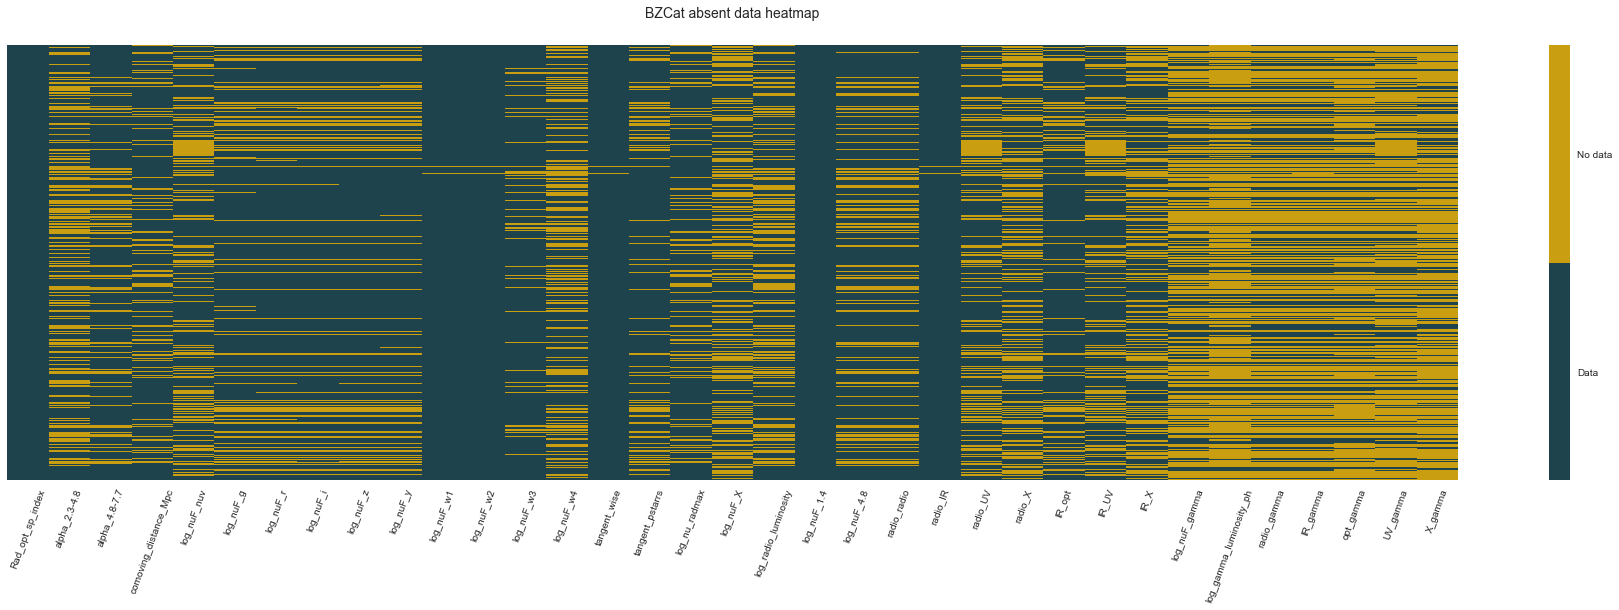

In [9]:
colors = ['#1e434c', '#c99e10'] 
fig = plt.figure(figsize=(32.5, 8))
ax = sns.heatmap(
    model_df.isnull(),  
    cmap=sns.color_palette(colors),
    yticklabels=False
)

colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0.25, 0.75])
colorbar.set_ticklabels(['Data', 'No data'])

plt.xticks(rotation=70)
ax.set_title('BZCat absent data heatmap', y=1.05, fontsize = 14);

Many features here are naturally correlated and have the same nature (like fluxes), while simulataneously having dispersed values; we will combine them further via PCA into single variables (e.g., fluxes -> flux). Nevetherless, there are other correlated features of different kinds. Let's look.

In [10]:
def get_correlated(corr_matrix, thres=0.7):
    """Getting correlated pairs from a correlation matrix 
       with correlation coefficients higher than the threshold

    Args:
        corr_matrix (pandas DataFrame): correlation matrix (e.g., from df.corr())
        thres (float, optional): threshold. Defaults to 0.7 (i.e., coeff > 0.7 or coeff < -0.7).

    Returns:
        pandas Series: correlated pairs and correlation coefficients
    """
    
    correlated_pairs = {}
    
    for col in corr_matrix.columns:
        positive_filter = corr_matrix[col] >= thres
        negative_filter = corr_matrix[col] <= -thres
        match_series = corr_matrix[col][positive_filter | negative_filter]
        for match in match_series.index:
            if match != col and match + ' -- ' + col not in correlated_pairs.keys():
                correlated_pairs.update({col + ' -- ' + match: match_series[match]})
   
    return pd.Series(correlated_pairs).sort_values()

In [11]:
hardnesses = [
    'Rad_opt_sp_index',
    'radio_radio',
    'radio_IR',
    'radio_UV',
    'radio_X',
    'IR_opt',
    'IR_UV',
    'IR_X'    
]

cols_to_look = [
    'tangent_wise', 'comoving_distance_Mpc',
    'tangent_pstarrs', 'log_nu_radmax', 'log_radio_luminosity', 
    ]
cols_to_look.extend(hardnesses)

get_correlated(model_df[cols_to_look].corr())

radio_X -- IR_X                                  0.703958
log_radio_luminosity -- Rad_opt_sp_index         0.706351
Rad_opt_sp_index -- radio_X                      0.713060
log_radio_luminosity -- radio_IR                 0.736221
Rad_opt_sp_index -- radio_UV                     0.741984
radio_UV -- radio_X                              0.769788
radio_IR -- radio_X                              0.777085
Rad_opt_sp_index -- radio_IR                     0.794226
radio_IR -- radio_UV                             0.815335
comoving_distance_Mpc -- log_radio_luminosity    0.846103
dtype: float64

In [12]:
model_df.columns

Index(['Rad_opt_sp_index', 'alpha_2.3-4.8', 'alpha_4.8-7.7',
       'comoving_distance_Mpc', 'log_nuF_nuv', 'log_nuF_g', 'log_nuF_r',
       'log_nuF_i', 'log_nuF_z', 'log_nuF_y', 'log_nuF_w1', 'log_nuF_w2',
       'log_nuF_w3', 'log_nuF_w4', 'tangent_wise', 'tangent_pstarrs',
       'log_nu_radmax', 'log_nuF_X', 'log_radio_luminosity', 'log_nuF_1.4',
       'log_nuF_4.8', 'radio_radio', 'radio_IR', 'radio_UV', 'radio_X',
       'IR_opt', 'IR_UV', 'IR_X', 'log_nuF_gamma', 'log_gamma_luminosity_ph',
       'radio_gamma', 'IR_gamma', 'opt_gamma', 'UV_gamma', 'X_gamma'],
      dtype='object')

In [13]:
shortwl_fluxes = [
    'log_nuF_X', 'log_nuF_nuv', 'log_nuF_g', 'log_nuF_r', 'log_nuF_i', 
    'log_nuF_z', 'log_nuF_y', 'log_nuF_w1', 'log_nuF_w2', 
    'log_nuF_w3', 'log_nuF_w4']                 
radio_fluxes = ['log_nuF_1.4', 'log_nuF_4.8']

In [14]:
from scipy.stats import kendalltau

kendalltau(model_df['log_nuF_g'], model_df['alpha_2.3-4.8'], nan_policy='omit')

KendalltauResult(correlation=-0.02783534042242326, pvalue=0.06963344054457628)

The following cells are commented: eventually, I didn't take variabilities to the model dataset, as it creates an "artificial" cluster with large variabilities, but this is only because of the great number of measurements.

Converting optical variabilities to the logarithmic scale

In [15]:
#model_df['g_var'] = np.log(model_df['g_var'])
#model_df['r_var'] = np.log(model_df['r_var'])
#model_df['i_var'] = np.log(model_df['i_var'])
#model_df['z_var'] = np.log(model_df['z_var'])
#model_df['y_var'] = np.log(model_df['y_var'])

There is a small artificial peak near $\rm{ var}_{7.7}=1$ in the distribution of the radio variability at 7.7 GHz. Let's try to clean it.

In [16]:
#sns.histplot(data=model_df, x='var_7.7', bins=30);

In [17]:
# Original scatterplot
#fig = px.scatter(model_df, x='var_7.7', y='var_4.8', width=650, height=400)
#fig.show()

In [18]:
# Masked scatterplot
#mask = (model_df['var_4.8']<0.8) & (model_df['var_7.7']>0.95)
#fig = px.scatter(model_df[~mask], x='var_7.7', y='var_4.8', width=650, height=400)
#fig.show()

#print(f'The number of points to be converted to NaNs: '
#      f'{model_df[mask].shape[0]}')

In [19]:
#model_df.mask(mask, np.NaN, inplace=True)

#sns.histplot(data=model_df, x='var_7.7', bins=30);

Saving the file to analyze via the Sweetviz report

In [20]:
model_df.to_csv('data/bzcat_for_profiling.csv')

**Outliers**

I'm cleaning the outliers manually by reviewing the Sweetvis report distributions. The removed objects are stored as anomalies in a separate dataframe. They don't paticipate in the clustering, but are going to be processed later using the KNN classification. Some strings are commented because these characteristics were not eventually included in the clustering dataset.

In [21]:
mask = model_df['Rad_opt_sp_index'] < -0.15
anomalies = model_df[mask].copy()
anomalies['Anomaly'] = 'Rad_opt_sp_index'
model_df = model_df[~mask]

# Further, alphas don't take part in clustering, thus no outliers filtration!!!

#mask = model_df['alpha_2.3-4.8'] < -2
#anomalies = pd.concat([anomalies, model_df[mask]])
#anomalies['Anomaly'].replace(np.NaN, 'alpha_2.3-4.8', inplace=True)
#model_df = model_df[~mask]

#mask = model_df['alpha_4.8-7.7'] < -4
#anomalies = pd.concat([anomalies, model_df[mask]])
#anomalies['Anomaly'].replace(np.NaN, 'alpha_4.8-7.7', inplace=True)
#model_df = model_df[~mask]

#mask = model_df['var_4.8'] < -0.2
#anomalies = pd.concat([anomalies, model_df[mask]])
#anomalies['Anomaly'].replace(np.NaN, 'var_4.8', inplace=True)
#model_df = model_df[~mask]

#mask = model_df['var_7.7'] < -0.3
#anomalies = pd.concat([anomalies, model_df[mask]])
#anomalies['Anomaly'].replace(np.NaN, 'var_7.7', inplace=True)
#model_df = model_df[~mask]

mask = (model_df['log_nuF_g'] < -14)  
anomalies = pd.concat([anomalies, model_df[mask]])
anomalies['Anomaly'].replace(np.NaN, 'log_nuF_g', inplace=True)
model_df = model_df[~mask]

mask = model_df['log_nuF_w1'] > -9.8
anomalies = pd.concat([anomalies, model_df[mask]])
anomalies['Anomaly'].replace(np.NaN, 'log_nuF_w1', inplace=True)
model_df = model_df[~mask]

mask = model_df['log_nuF_w2'] > -9.8
anomalies = pd.concat([anomalies, model_df[mask]])
anomalies['Anomaly'].replace(np.NaN, 'log_nuF_w2', inplace=True)
model_df = model_df[~mask]

mask = model_df['log_nuF_w3'] > -9.8
anomalies = pd.concat([anomalies, model_df[mask]])
anomalies['Anomaly'].replace(np.NaN, 'log_nuF_w3', inplace=True)
model_df = model_df[~mask]

mask = model_df['log_nuF_w4'] > -9.8
anomalies = pd.concat([anomalies, model_df[mask]])
anomalies['Anomaly'].replace(np.NaN, 'log_nuF_w4', inplace=True)
model_df = model_df[~mask]

mask = (model_df['tangent_wise'] < -1.3) | (model_df['tangent_wise'] > 3.2)
anomalies = pd.concat([anomalies, model_df[mask]])
anomalies['Anomaly'].replace(np.NaN, 'tangent_wise', inplace=True)
model_df = model_df[~mask]

mask = (model_df['tangent_pstarrs'] < -4) | (model_df['tangent_pstarrs'] > 4)
anomalies = pd.concat([anomalies, model_df[mask]])
anomalies['Anomaly'].replace(np.NaN, 'tangent_pstarrs', inplace=True)
model_df = model_df[~mask]

mask = (model_df['log_nu_radmax'] < 11) | (model_df['log_nu_radmax'] > 18)
anomalies = pd.concat([anomalies, model_df[mask]])
anomalies['Anomaly'].replace(np.NaN, 'log_nu_radmax', inplace=True)
model_df = model_df[~mask]

#mask = model_df['i_abs']  > -18
#anomalies = pd.concat([anomalies, model_df[mask]])
#anomalies['Anomaly'].replace(np.NaN, 'i_abs', inplace=True)
#model_df = model_df[~mask]

#mask = model_df['w1_abs']  > -22
#anomalies = pd.concat([anomalies, model_df[mask]])
#anomalies['Anomaly'].replace(np.NaN, 'w1_abs', inplace=True)
#model_df = model_df[~mask]

mask = model_df['log_nuF_X'] > -10
anomalies = pd.concat([anomalies, model_df[mask]])
anomalies['Anomaly'].replace(np.NaN, 'log_nuF_X', inplace=True)
model_df = model_df[~mask]

mask = model_df['log_nuF_1.4'] > -11.4
anomalies = pd.concat([anomalies, model_df[mask]])
anomalies['Anomaly'].replace(np.NaN, 'log_nuF_1.4', inplace=True)
model_df = model_df[~mask]

mask = model_df['log_nuF_4.8'] > -11
anomalies = pd.concat([anomalies, model_df[mask]])
anomalies['Anomaly'].replace(np.NaN, 'log_nuF_4.8', inplace=True)
model_df = model_df[~mask]

#mask = model_df['g_var'] < -6
#anomalies = pd.concat([anomalies, model_df[mask]])
#anomalies['Anomaly'].replace(np.NaN, 'g_var', inplace=True)
#model_df = model_df[~mask]

#mask = model_df['r_var'] < -6
#anomalies = pd.concat([anomalies, model_df[mask]])
#anomalies['Anomaly'].replace(np.NaN, 'r_var', inplace=True)
#model_df = model_df[~mask]

#mask = model_df['i_var'] < -4
#anomalies = pd.concat([anomalies, model_df[mask]])
#anomalies['Anomaly'].replace(np.NaN, 'i_var', inplace=True)
#model_df = model_df[~mask]

#mask = model_df['z_var'] < -4.5
#anomalies = pd.concat([anomalies, model_df[mask]])
#anomalies['Anomaly'].replace(np.NaN, 'z_var', inplace=True)
#model_df = model_df[~mask]

#mask = model_df['y_var'] < -4
#anomalies = pd.concat([anomalies, model_df[mask]])
#anomalies['Anomaly'].replace(np.NaN, 'y_var', inplace=True)
#model_df = model_df[~mask]

#mask = (model_df['log_radio_luminosity'] < 52)
mask = (model_df['log_radio_luminosity'] < 22.5)
anomalies = pd.concat([anomalies, model_df[mask]])
anomalies['Anomaly'].replace(np.NaN, 'log_radio_luminosity', inplace=True)
model_df = model_df[~mask]

#mask = (model_df['radio_radio']<-1.5)
#anomalies = pd.concat([anomalies, model_df[mask]])
#anomalies['Anomaly'].replace(np.NaN, 'radio_radio', inplace=True)
#model_df = model_df[~mask]

mask = (model_df['radio_IR']>0.5)
anomalies = pd.concat([anomalies, model_df[mask]])
anomalies['Anomaly'].replace(np.NaN, 'radio_IR', inplace=True)
model_df = model_df[~mask]

mask = (model_df['radio_X']>0.7)
anomalies = pd.concat([anomalies, model_df[mask]])
anomalies['Anomaly'].replace(np.NaN, 'radio_X', inplace=True)
model_df = model_df[~mask]

mask = (model_df['IR_opt']>1.7) 
anomalies = pd.concat([anomalies, model_df[mask]])
anomalies['Anomaly'].replace(np.NaN, 'IR_opt', inplace=True)
model_df = model_df[~mask]

mask = (model_df['IR_UV']<-1.25) | (model_df['IR_UV']>2)
anomalies = pd.concat([anomalies, model_df[mask]])
anomalies['Anomaly'].replace(np.NaN, 'IR_UV', inplace=True)
model_df = model_df[~mask]

mask = (model_df['IR_X']>2.15)
anomalies = pd.concat([anomalies, model_df[mask]])
anomalies['Anomaly'].replace(np.NaN, 'IR_X', inplace=True)
model_df = model_df[~mask]

mask = (model_df['log_gamma_luminosity_ph']<45)
anomalies = pd.concat([anomalies, model_df[mask]])
anomalies['Anomaly'].replace(np.NaN, 'log_gamma_luminosity_ph', inplace=True)
model_df = model_df[~mask]

mask = (model_df['IR_gamma']>0)
anomalies = pd.concat([anomalies, model_df[mask]])
anomalies['Anomaly'].replace(np.NaN, 'IR_gamma', inplace=True)
model_df = model_df[~mask]

mask = (model_df['opt_gamma']>0.5)
anomalies = pd.concat([anomalies, model_df[mask]])
anomalies['Anomaly'].replace(np.NaN, 'opt_gamma', inplace=True)
model_df = model_df[~mask]

print(f'Number of outliers: {anomalies.shape[0]}')
anomalies.head(3)

Number of outliers: 36


,Rad_opt_sp_index,alpha_2.3-4.8,alpha_4.8-7.7,comoving_distance_Mpc,log_nuF_nuv,log_nuF_g,log_nuF_r,log_nuF_i,log_nuF_z,log_nuF_y,...,IR_UV,IR_X,log_nuF_gamma,log_gamma_luminosity_ph,radio_gamma,IR_gamma,opt_gamma,UV_gamma,X_gamma,Anomaly
916,-0.260,NaN,0.632,88.096983,-11.627384,-9.898098,-9.825438,-9.866171,-9.917871,-10.633408,...,0.614573,1.174275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Rad_opt_sp_index
2777,-0.363,NaN,-0.149,118.733490,-11.572598,-9.977698,-9.943838,-9.995771,-10.055871,-10.862368,...,0.465787,0.025721,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Rad_opt_sp_index
3042,-0.269,NaN,NaN,248.861612,-12.627066,-11.927978,-11.666238,-11.595371,-11.551871,-11.597888,...,0.760655,-0.160877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Rad_opt_sp_index


---

## 2. Preprocessing

In this section we deal with the first dimensionality reduction where some deeply connected physical characteristics are combined to corresponding single variables

The features of the same nature to combine to single variables (e.g., radio_vars -> radio_var). Most are correlated with each other.

In [22]:
#radio_vars = ['var_4.8', 'var_7.7']                         
#opt_vars = ['g_var', 'r_var', 'i_var', 'z_var', 'y_var']  
shortwl_fluxes = [
    'log_nuF_X', 'log_nuF_nuv', 'log_nuF_g', 'log_nuF_r', 'log_nuF_i', 
    'log_nuF_z', 'log_nuF_y', 'log_nuF_w1', 'log_nuF_w2', 
    'log_nuF_w3', 'log_nuF_w4']                 
radio_fluxes = ['log_nuF_1.4', 'log_nuF_4.8']

First scaling. Several scalings and several PCA transformations will be made during the project, this is due to the approach of gradual dimensionality reduction, also we use probabilistic PCA for guessing the missing values and this nonparametric method makes its own adjustments to the data processing.

In [23]:
scaler1 = StandardScaler()
model_df = pd.DataFrame(scaler1.fit_transform(model_df),
                            columns=model_df.columns, index=model_df.index)

# Save scaling model to the drive
with open('data/model/scaler1.pkl', 'wb') as f:
    pickle.dump(scaler1, f)

model_df.describe()

,Rad_opt_sp_index,alpha_2.3-4.8,alpha_4.8-7.7,comoving_distance_Mpc,log_nuF_nuv,log_nuF_g,log_nuF_r,log_nuF_i,log_nuF_z,log_nuF_y,...,IR_opt,IR_UV,IR_X,log_nuF_gamma,log_gamma_luminosity_ph,radio_gamma,IR_gamma,opt_gamma,UV_gamma,X_gamma
count,3.504000e+03,2.286000e+03,2.933000e+03,2.808000e+03,2.488000e+03,2.841000e+03,2.870000e+03,2.886000e+03,2.878000e+03,2.845000e+03,...,2.858000e+03,2.469000e+03,2.196000e+03,1.540000e+03,1.025000e+03,1.532000e+03,1.525000e+03,1.269000e+03,1.143000e+03,1.132000e+03
mean,-1.439741e-16,-1.010177e-17,1.211290e-18,-6.579099e-17,7.596639e-16,-2.429126e-15,-3.334847e-15,-2.752553e-15,-1.006685e-15,-5.294730e-16,...,4.350769e-17,-2.050473e-17,-1.617811e-17,2.629931e-16,7.729319e-16,1.936368e-16,7.268503e-16,7.838927e-17,6.527295e-17,1.883064e-17
std,1.000143e+00,1.000219e+00,1.000171e+00,1.000178e+00,1.000201e+00,1.000176e+00,1.000174e+00,1.000173e+00,1.000174e+00,1.000176e+00,...,1.000175e+00,1.000203e+00,1.000228e+00,1.000325e+00,1.000488e+00,1.000327e+00,1.000328e+00,1.000394e+00,1.000438e+00,1.000442e+00
min,-3.858212e+00,-6.997903e+00,-5.564657e+00,-1.784782e+00,-2.956908e+00,-2.501777e+00,-3.355773e+00,-2.822175e+00,-2.781763e+00,-2.786882e+00,...,-3.845180e+00,-2.617965e+00,-3.273770e+00,-2.606374e+00,-2.521336e+00,-3.489254e+00,-4.496852e+00,-3.483761e+00,-3.633656e+00,-2.736573e+00
25%,-7.011750e-01,-5.707585e-01,-5.017302e-01,-8.590367e-01,-7.017997e-01,-6.929395e-01,-6.718909e-01,-6.621318e-01,-6.877564e-01,-7.379957e-01,...,-6.905867e-01,-7.654698e-01,-6.088251e-01,-7.033936e-01,-7.997637e-01,-7.397132e-01,-5.480019e-01,-6.165859e-01,-5.702217e-01,-7.461951e-01
50%,1.107871e-01,-1.621147e-02,4.691649e-02,-6.862961e-04,-4.342481e-02,-1.887626e-02,-3.629567e-02,-5.317628e-02,-6.945044e-02,-1.260563e-01,...,-1.417189e-01,-1.412754e-01,9.315761e-02,-9.933558e-02,1.581354e-01,-4.789352e-02,4.052869e-02,1.600253e-01,1.487663e-01,-1.024684e-01
75%,7.571516e-01,5.842678e-01,5.760152e-01,7.881410e-01,6.742587e-01,6.407938e-01,6.332073e-01,6.251465e-01,6.219625e-01,6.310516e-01,...,5.881709e-01,6.879026e-01,6.630338e-01,6.238571e-01,8.070449e-01,7.180286e-01,6.455127e-01,6.665377e-01,6.672842e-01,7.126542e-01
max,3.091543e+00,4.570285e+00,4.166328e+00,3.040395e+00,4.631013e+00,4.853215e+00,4.975642e+00,5.093003e+00,5.160262e+00,5.434051e+00,...,4.685736e+00,3.894532e+00,3.195390e+00,4.029402e+00,2.337026e+00,3.213402e+00,3.615189e+00,3.277148e+00,3.031552e+00,2.730892e+00


**Probabilistic PCA**

Two steps:
1. Guessing the missing values with probabilistic PCA (Tipping and Bishop 1999, “Mixtures of probabilistic principal component analysers”, Neural Computation 11(2),
pp. 443–482. MIT Press.). I used Ludvig Hult's code: https://github.com/el-hult/pyppca. The algorithm is actually from Porta et al., 2005, Autonomous Robots, 18, 59 ([https://inria.hal.science/inria-00321476](https://inria.hal.science/inria-00321476)). 
2. Converting the features to a single principal component using the standard sklearn PCA.

In [24]:
def ppca_transform(df, cols, model_name):
    np.random.seed(42)
    
    # The PPCA algorithm produces data of the initial dimension
    # (filled in missing values)
    Y = np.array(df[cols])
    C, ss, M, X, Ye = ppca(Y, 2, False)  # Here 2d latent space (the minimum)
    
    # Reducing dimensionality to 1
    pipeline_pca1 = Pipeline([
        ('scaler', StandardScaler()),  # scaling after ppca
        ('pca', (PCA(n_components=1, random_state=42)))])  # sklearn pca
    out_col = pipeline_pca1.fit_transform(Ye)
    
    # The combined value is NaN if all initial values are NaNs 
    # (no filling with mean values)
    out_col[df[cols].isnull().all(axis=1)] = np.NaN
    
    # Saving sklearn PCA models
    filename = 'data/model/pca1_' + model_name + '.pkl'
    with open(filename, 'wb') as f:
        pickle.dump(pipeline_pca1, f)    
        
    return out_col

In [25]:
#model_df['radio_var'] = ppca_transform(model_df, radio_vars, 'radio_vars')
#model_df['opt_var'] = ppca_transform(model_df, opt_vars, 'opt_vars')
model_df['shortwl_flux'] = ppca_transform(model_df, shortwl_fluxes, 'shortwl_fluxes')
model_df['radio_flux'] = ppca_transform(model_df, radio_fluxes, 'radio_fluxes')
#cols_drop = radio_vars + opt_vars + shortwl_fluxes + radio_fluxes
cols_drop = shortwl_fluxes + radio_fluxes
model_df.drop(columns=cols_drop, inplace=True)

scaler2 = StandardScaler()
model_df = pd.DataFrame(scaler2.fit_transform(model_df),
                        columns=model_df.columns, index=model_df.index)   
with open('data/model/scaler2.pkl', 'wb') as f:
        pickle.dump(scaler2, f)

#new_cols = ['radio_var', 'opt_var', 'shortwl_flux', 'radio_flux']
new_cols = ['shortwl_flux', 'radio_flux']
bzcat[new_cols] = model_df[new_cols]

---

## 3. Clustering

Some functions

In [26]:
def plot_metrics(X):
    """Plot some metrics depending on the number of clusters"""
    inertia = []
    silhouette = []
    calinski_harabasz = []
    davis_bouldin = []
    
    for n_cl in range(2, 11):
        kmeans = cluster.KMeans(n_clusters=n_cl, random_state=42)
        kmeans.fit(X)
    
        inertia.append(kmeans.inertia_)
        silhouette.append(metrics.silhouette_score(
            X, kmeans.labels_))
        calinski_harabasz.append(metrics.calinski_harabasz_score(
            X, kmeans.labels_))
        davis_bouldin.append(metrics.davies_bouldin_score(
            X, kmeans.labels_))
        
    fig, ax = plt.subplots(1, 4, figsize=(24,5))
    
    ax[0].plot(range(2, 11), inertia, 's-', label='inertia')
    ax[1].plot(range(2, 11), silhouette, 's-', label='silhouette')
    ax[2].plot(range(2, 11), calinski_harabasz, 's-', label='calinski-harabasz')
    ax[3].plot(range(2, 11), davis_bouldin, 's-', label='davis-bouldin')
    ax[0].legend(prop={'size': 20})
    ax[1].legend(prop={'size': 20})
    ax[2].legend(prop={'size': 20})
    ax[3].legend(prop={'size': 20});
    
    
def make_kmeans_clusters(model_df, dataset_df, n_clusters, perplexity):
    """Make KMeans clusters and calculate some metrics"""
    kmeans = cluster.KMeans(n_clusters=n_clusters, random_state=42)
    dataset_df['cluster_kmeans'] = kmeans.fit_predict(model_df)
    tsne = TSNE(n_components=2, perplexity=perplexity, init='pca', 
                         learning_rate='auto', random_state=42)
    df_tsne = pd.DataFrame(tsne.fit_transform(model_df))
    df_tsne['c'] = kmeans.labels_
    sns.scatterplot(x=df_tsne[0], y=df_tsne[1], hue=df_tsne['c'], 
        palette='bright')
    plt.title('2D t-SNE representation')
    print('Silhouette: {:.3f}'.format(
        metrics.silhouette_score(model_df, kmeans.labels_)))
    print('Davis-Bouldin: {:.3f}'.format(
        metrics.davies_bouldin_score(model_df, kmeans.labels_)))
    print('Calinski-Harabatz: {:.3f}'.format(
        metrics.calinski_harabasz_score(model_df, kmeans.labels_)))
    print(f'Inertia: {kmeans.inertia_:.3f}')
    centroid_dist = pd.DataFrame(
        distance_matrix(kmeans.cluster_centers_, kmeans.cluster_centers_),
        index=range(n_clusters), columns=range(n_clusters))
    print(centroid_dist)
    
    
def yb_elbow(model_df):
    """Yellowbrick elbow visualizer"""
    vis_distortion = KElbowVisualizer(
         cluster.KMeans(), metrics='distortion', timings=False)
    vis_distortion.fit(model_df)
    vis_distortion.show();


def plot_distr(dataset_df, cols, file=None):
    "Feature distributions for different clusters"
    plt.rcParams['axes.labelsize'] = 18
    sns.set_style({'axes.grid' : False})
    
    nrows = int(np.ceil(len(cols) / 4))
    fig, axes = plt.subplots(nrows, 4, figsize=(25, 3.25*nrows))
    i = 0
    for col, ax in  zip(cols, axes.flatten()):
        sns.boxplot(
            data=dataset_df, x=col, y='cluster_kmeans', 
            hue='cluster_kmeans', palette='tab10',
            orient='h', ax=ax).set(ylabel='Cluster')
        ax.get_legend().remove()
    plt.tight_layout()
    if file is not None:
        plt.savefig('figs/' + file + '.eps', format='eps', bbox_inches='tight')  
        plt.savefig('figs/' + file + '.png', format='png', bbox_inches='tight')      
    plt.rcParams['axes.labelsize'] = 10
    return fig, axes

    
def kl_div(nonans_df, filled_df, bins=10):
    """Kullback-Leibler divergence (sum for each column)"""
    kldiv = 0
    for col in nonans_df:
        hist_range = (nonans_df[col].min(), nonans_df[col].max())
        q, _ = np.histogram(nonans_df[col], bins=bins, range=hist_range)
        q = q / np.sum(q)
        p, _ = np.histogram(filled_df[col], bins=bins, range=hist_range)
        p = p / np.sum(p)
        kldiv += np.sum(rel_entr(p, q))
    print(f'Kullback-Leibler divergence: {kldiv}')
    
    
def kl_div_clusters(nonans_df, filled_df, bins=5):
    """Kullback-Leibler divergence (sum for each column and each cluster)"""
    kldiv = 0
    n_clusters = nonans_df['cluster_kmeans'].nunique()
    cols = list(nonans_df.columns)
    cols.remove('cluster_kmeans')
    for col in cols:
        for cluster in range(n_clusters):
            distr_nonan = nonans_df[nonans_df['cluster_kmeans'] == cluster][col]
            distr_filled = filled_df[filled_df['cluster_kmeans'] == cluster][col]
            hist_range = (distr_nonan.min(), distr_nonan.max())
            q, _ = np.histogram(distr_nonan, bins=bins, range=hist_range)
            q = q / np.sum(q)
            p, _ = np.histogram(distr_filled, bins=bins, range=hist_range)
            p = p / np.sum(p)
            kldiv += np.sum(rel_entr(p, q))
    print(f'Kullback-Leibler divergence: {kldiv}')

Final feature selection. I drop the alpha spectral indices and radio-to-radio hardness: the experiments have shown that they stay pretty much the same for different clusters

In [27]:
model_df.drop(columns=['alpha_2.3-4.8', 'alpha_4.8-7.7', 'radio_radio'], inplace=True)

The final model dataframe

In [28]:
model_df

,Rad_opt_sp_index,comoving_distance_Mpc,tangent_wise,tangent_pstarrs,log_nu_radmax,log_radio_luminosity,radio_IR,radio_UV,radio_X,IR_opt,...,IR_X,log_nuF_gamma,log_gamma_luminosity_ph,radio_gamma,IR_gamma,opt_gamma,UV_gamma,X_gamma,shortwl_flux,radio_flux
0,0.677024,0.437681,-1.009758,NaN,-0.190938,0.701049,0.903835,0.395194,1.645203,NaN,...,1.345663,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.505266,0.814345
1,0.431298,1.181452,-0.855818,1.039128,-0.239439,0.981868,0.927303,0.716328,NaN,-0.904244,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.124431,0.513114
2,1.798813,1.859536,-0.432062,-1.176329,-0.617801,0.918057,1.502701,NaN,NaN,0.773301,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.930101,0.183932
3,-0.145622,NaN,-0.035526,0.113356,NaN,NaN,-0.611770,-0.110777,0.383868,0.122532,...,1.082707,0.232428,NaN,-0.013500,0.550305,0.494421,0.032818,-0.502003,1.042186,0.103262
4,0.671682,-0.787640,0.727720,-0.646036,0.715796,-1.171655,0.523783,0.568635,NaN,-0.304153,...,NaN,-1.363539,-0.885324,0.867996,0.007343,0.322629,0.054138,NaN,-0.851981,-0.605888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3556,0.612922,0.176838,-0.283389,1.436491,0.081620,0.598480,0.726614,0.216493,0.954425,-0.031572,...,0.448998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.309187,1.057764
3557,0.837279,0.348856,-0.814475,0.098174,-0.565218,0.334140,0.872217,1.354727,0.635580,0.915682,...,-0.227064,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.710992,0.580495
3558,-1.475744,-1.406890,0.757284,NaN,4.497643,NaN,-1.067179,-1.200071,-2.238264,NaN,...,-2.571495,-0.186614,-1.227536,-0.488807,0.593761,NaN,1.008013,2.400556,1.702819,-0.420585
3559,0.880014,1.642274,-1.312682,1.133350,-0.231740,0.830454,1.705243,NaN,0.624972,-1.354717,...,-1.204407,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.578743,0.846622


In [29]:
model_df.columns

Index(['Rad_opt_sp_index', 'comoving_distance_Mpc', 'tangent_wise',
       'tangent_pstarrs', 'log_nu_radmax', 'log_radio_luminosity', 'radio_IR',
       'radio_UV', 'radio_X', 'IR_opt', 'IR_UV', 'IR_X', 'log_nuF_gamma',
       'log_gamma_luminosity_ph', 'radio_gamma', 'IR_gamma', 'opt_gamma',
       'UV_gamma', 'X_gamma', 'shortwl_flux', 'radio_flux'],
      dtype='object')

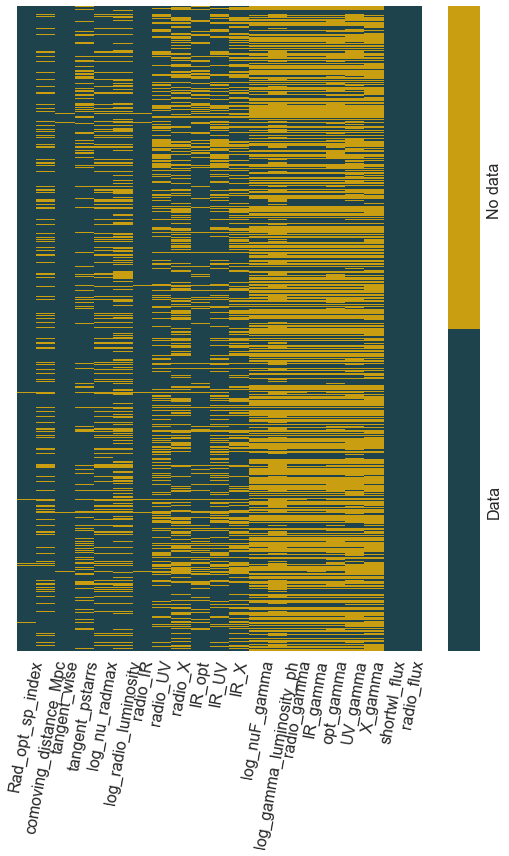

In [30]:
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

colors = ['#1e434c', '#c99e10'] 
#colors = ['#A96946', '#ECCDB1'] 
fig = plt.figure(figsize=(7.5, 12))
ax = sns.heatmap(
    model_df.isnull(),  
    cmap=sns.color_palette(colors),
    yticklabels=False
)

colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0.25, 0.75])
colorbar.set_ticklabels(['Data', 'No data'], fontsize=16, rotation=90)

#labels=[
#    'Radio-to-opt. sp. index',
#    'Distance, Mpc',
#    'Spectrum slope (WISE)',
#    '(Pan-STARRS)',
#    r'$\log \nu_{\rm peak}$, [Hz]',
#    r'$\log L_{4.7}$, [W/Hz]',
#    'radio/IR',
#    'radio/UV',
#    'radio/X',
#    'IR/opt',
#    'IR/UV',
#    'IR/X',
#    r'$f_{\rm IR-X}$',
#    r'$f_{\rm radio}$'
#]
#ax.set_xticklabels(labels)

plt.xticks(rotation=80, fontsize=16)
#ax.set_title('Model dataset', y=1.05, fontsize=16)
plt.tight_layout()

plt.savefig('figs/model_dataset.png', format='png', bbox_inches='tight')

### 3.1. PCA + KMeans model with all missing values dropped

In [31]:
model_df.isnull().mean()

Rad_opt_sp_index           0.005957
comoving_distance_Mpc      0.203404
tangent_wise               0.014752
tangent_pstarrs            0.183262
log_nu_radmax              0.208511
log_radio_luminosity       0.329078
radio_IR                   0.017589
radio_UV                   0.294468
radio_X                    0.370496
IR_opt                     0.189220
IR_UV                      0.299574
IR_X                       0.377021
log_nuF_gamma              0.563121
log_gamma_luminosity_ph    0.709220
radio_gamma                0.565390
IR_gamma                   0.567376
opt_gamma                  0.640000
UV_gamma                   0.675745
X_gamma                    0.678865
shortwl_flux               0.002553
radio_flux                 0.000000
dtype: float64

In [32]:
model_df.dropna(subset='log_nuF_gamma').isnull().mean()

Rad_opt_sp_index           0.007792
comoving_distance_Mpc      0.334416
tangent_wise               0.009740
tangent_pstarrs            0.178571
log_nu_radmax              0.336364
log_radio_luminosity       0.432468
radio_IR                   0.014935
radio_UV                   0.257792
radio_X                    0.266883
IR_opt                     0.181818
IR_UV                      0.261688
IR_X                       0.268831
log_nuF_gamma              0.000000
log_gamma_luminosity_ph    0.334416
radio_gamma                0.005195
IR_gamma                   0.009740
opt_gamma                  0.175974
UV_gamma                   0.257792
X_gamma                    0.264935
shortwl_flux               0.001948
radio_flux                 0.000000
dtype: float64

In [33]:
model_pca_dropna = model_df.copy()
model_pca_dropna.dropna(inplace=True)
bzcat_pca_dropna = bzcat.iloc[model_pca_dropna.index,:].copy()

# Rescaling after NaNs dropping
scaler = StandardScaler()
model_pca_dropna = pd.DataFrame(scaler.fit_transform(model_pca_dropna),
                        columns=model_pca_dropna.columns, index=model_pca_dropna.index)

model_pca_dropna.shape

(396, 21)

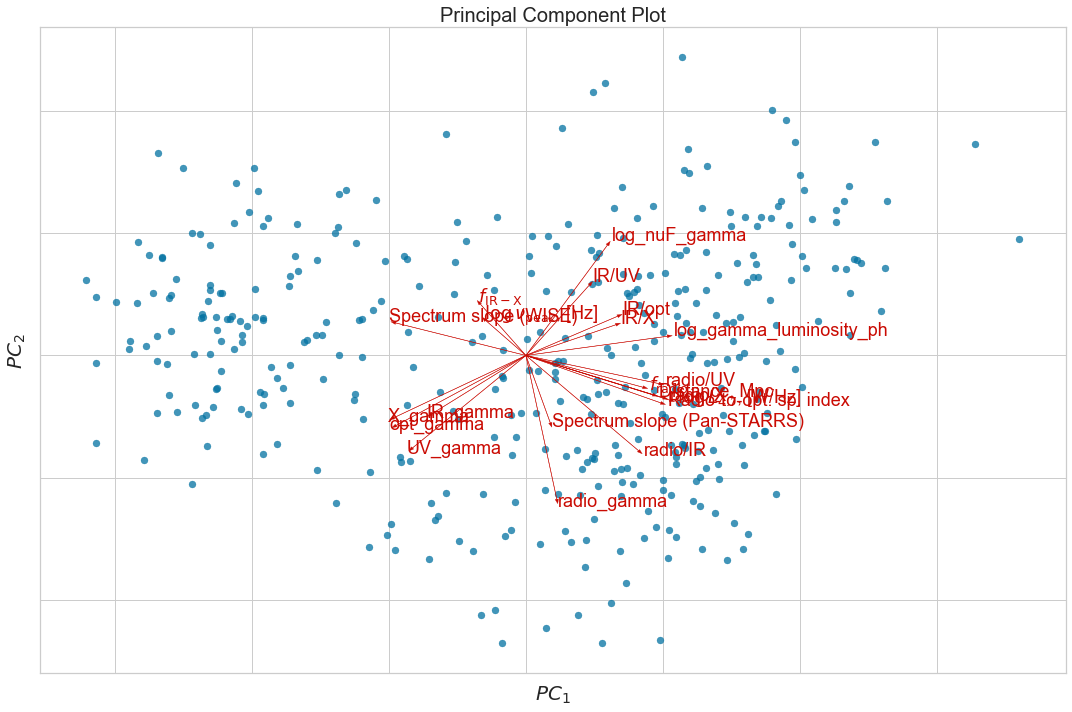

In [34]:
# Yellowbricks visualization
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 20

tmp_tab = model_pca_dropna.copy()
tmp_tab.rename(
    columns={
        'Rad_opt_sp_index': 'Radio-to-opt. sp. index',
        'comoving_distance_Mpc': 'Distance, Mpc',
        'tangent_wise': 'Spectrum slope (WISE)',
        'tangent_pstarrs': 'Spectrum slope (Pan-STARRS)',
        'log_nu_radmax': r'$\log \nu_{\rm peak}$, [Hz]',
        'log_radio_luminosity': r'$\log L_{4.7}$, [W/Hz]',
        'radio_IR': 'radio/IR',
        'radio_UV': 'radio/UV',
        'radio_X': 'radio/X',
        'IR_opt': 'IR/opt',
        'IR_UV': 'IR/UV',
        'IR_X': 'IR/X',
        'shortwl_flux': r'$f_{\rm IR-X}$',
        'radio_flux': r'$f_{\rm radio}$'
        },
    inplace=True
)

from yellowbrick.features import RadViz
visualizer = RadViz(size=(1080, 720))

from yellowbrick.features import PCA as PCA_yb

visualizer = PCA_yb(scale=True, proj_features=True)
visualizer.fit_transform(tmp_tab)

for label in visualizer.ax.texts:
    label.set_size(18)
visualizer.show(outpath='figs/PCA_biplot.png');

In [35]:
# Contribution of the features to the two first PCs

scores = np.linalg.norm(visualizer.pca_components_, axis=0)
scores

array([0.31620129, 0.28863011, 0.28558075, 0.23083513, 0.14262619,
       0.32793775, 0.39202967, 0.28555654, 0.31194205, 0.22759655,
       0.26864842, 0.20944223, 0.40486797, 0.29374152, 0.48510064,
       0.27372532, 0.35226475, 0.38550273, 0.33863283, 0.19545987,
       0.25995585])

In [36]:
np.linalg.norm(visualizer.pca_components_, axis=0) / np.sum(scores)

array([0.05038038, 0.04598746, 0.04550161, 0.03677898, 0.02272464,
       0.05225035, 0.06246212, 0.04549775, 0.04970176, 0.03626298,
       0.04280378, 0.03337045, 0.06450765, 0.04680186, 0.07729113,
       0.04361268, 0.05612638, 0.06142219, 0.0539544 , 0.03114264,
       0.04141879])

In [37]:
visualizer.features_

array(['Radio-to-opt. sp. index', 'Distance, Mpc',
       'Spectrum slope (WISE)', 'Spectrum slope (Pan-STARRS)',
       '$\\log \\nu_{\\rm peak}$, [Hz]', '$\\log L_{4.7}$, [W/Hz]',
       'radio/IR', 'radio/UV', 'radio/X', 'IR/opt', 'IR/UV', 'IR/X',
       'log_nuF_gamma', 'log_gamma_luminosity_ph', 'radio_gamma',
       'IR_gamma', 'opt_gamma', 'UV_gamma', 'X_gamma', '$f_{\\rm IR-X}$',
       '$f_{\\rm radio}$'], dtype=object)

PCA dimensionality reduction with 90% dispersion explained

In [469]:
# pca
pca = PCA(n_components=0.9, random_state=42)
X = pca.fit_transform(model_pca_dropna)
print(f'The number of principal components: {pca.n_components_}')

The number of principal components: 6


Looking at the metrics (the optimal number of clusters)

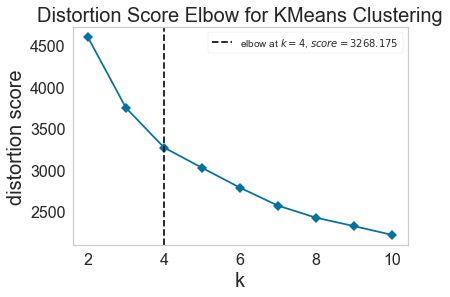

In [470]:
yb_elbow(X)

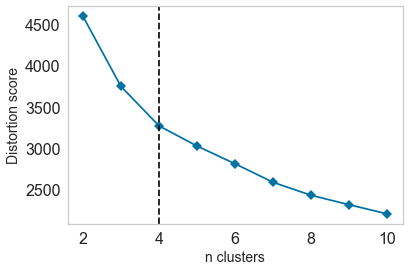

In [471]:
# Figure for the paper

vis_distortion = KElbowVisualizer(
    cluster.KMeans(), timings=False)
vis_distortion.fit(X)
vis_distortion.ax.set_xlabel('n clusters', fontsize=14)
vis_distortion.ax.set_ylabel('Distortion score', fontsize=14)

plt.savefig('./figs/elbow.eps', format='eps')

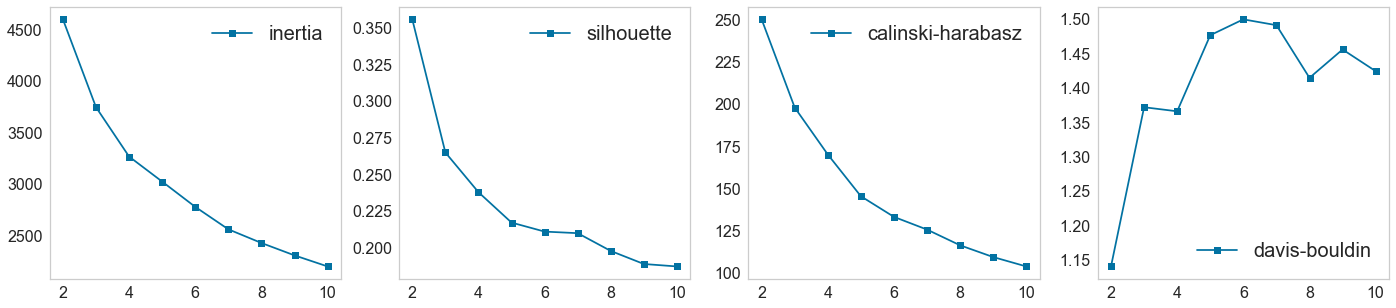

In [472]:
plot_metrics(X)

Making five clusters using K-Means. Several clustering algorithms have been tested, this is the best in our case. We also evaluate clustering metrics, distances between the centroids (in 8d space, the table), and plot the 2d and 3d representations of the 8d space (t-SNE is used: t-distributed stochastic neighbor embedding).

/home/dkudr/miniconda3/envs/bzcat/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Silhouette: 0.217
Davis-Bouldin: 1.476
Calinski-Harabatz: 145.350
Inertia: 3025.234
          0         1         2         3         4
0  0.000000  8.354585  6.538939  4.156789  6.609765
1  8.354585  0.000000  4.353518  6.066856  3.081225
2  6.538939  4.353518  0.000000  3.821566  3.883800
3  4.156789  6.066856  3.821566  0.000000  3.875961
4  6.609765  3.081225  3.883800  3.875961  0.000000


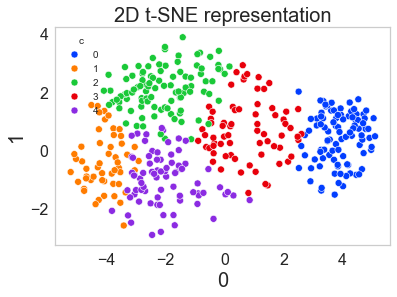

In [473]:
make_kmeans_clusters(X, bzcat_pca_dropna, 5, 150)

Reassigning cluster numbers (based on the number of BL Lac objects in a cluster)  

In [474]:
#bzcat_pca_dropna['cluster_kmeans'].replace({2:0, 1:1, 3:2, 4:3, 0:4}, 
#                                           inplace=True)
bzcat_pca_dropna['cluster_kmeans'].replace({0:0, 3:1, 4:2, 2:3, 1:4}, 
                                           inplace=True)

/home/dkudr/miniconda3/envs/bzcat/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


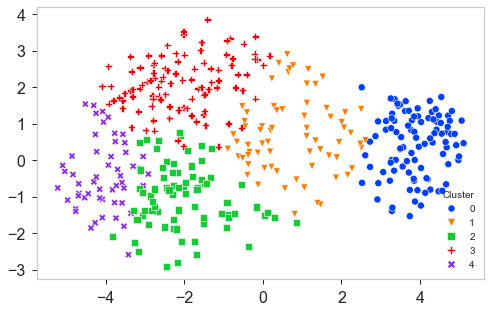

In [475]:
# Figure for the paper

tsne = TSNE(n_components=2, perplexity=150, init='pca',
            learning_rate='auto', random_state=42)
df_tsne = pd.DataFrame(tsne.fit_transform(X))
df_tsne['Cluster'] = bzcat_pca_dropna.reset_index()['cluster_kmeans']

plt.figure(figsize=(8, 5))
ax = sns.scatterplot(data=df_tsne, x=0, y=1, hue='Cluster', palette='bright', 
                style='Cluster', markers=['o', 'v', 's', 'P', 'X'], s=50)
ax.tick_params(direction='out', length=5, width=1)
plt.grid(False)
plt.legend(title='Cluster', loc='lower right')
plt.xlabel('', fontsize=14)
plt.ylabel('', fontsize=14)
plt.savefig('./figs/tsne_nonans.eps', format='eps')

In [476]:
bzcat_full = pd.read_csv('data/BZCAT_RESULT_RAA1.csv')

bzcat_pca_dropna = bzcat_pca_dropna.merge(bzcat_full[['BZCAT5 Source name', 'cluster']], on='BZCAT5 Source name', how='left')

/home/dkudr/miniconda3/envs/bzcat/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


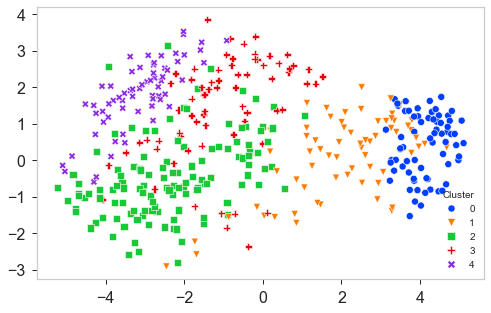

In [477]:
tsne = TSNE(n_components=2, perplexity=150, init='pca',
            learning_rate='auto', random_state=42)
df_tsne = pd.DataFrame(tsne.fit_transform(X))
df_tsne['Cluster'] = bzcat_pca_dropna.reset_index()['cluster']

plt.figure(figsize=(8, 5))
ax = sns.scatterplot(data=df_tsne, x=0, y=1, hue='Cluster', palette='bright', 
                style='Cluster', markers=['o', 'v', 's', 'P', 'X'], s=50)
ax.tick_params(direction='out', length=5, width=1)
plt.grid(False)
plt.legend(title='Cluster', loc='lower right')
plt.xlabel('', fontsize=14)
plt.ylabel('', fontsize=14)
plt.savefig('./figs/tsne_nonans.eps', format='eps')

In [478]:
metrics.rand_score(bzcat_pca_dropna['cluster_kmeans'], bzcat_pca_dropna['cluster'])

0.7719601074031454

TeV blazars

/home/dkudr/miniconda3/envs/bzcat/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


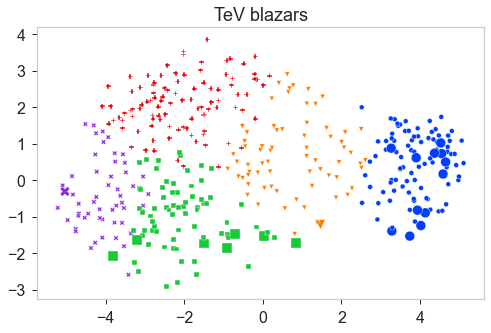

In [479]:
# TeV blazars

tsne = TSNE(n_components=2, perplexity=150, init='pca',
            learning_rate='auto', random_state=42)
df_tsne = pd.DataFrame(tsne.fit_transform(X))
df_tsne['Cluster'] = bzcat_pca_dropna.reset_index()['cluster_kmeans']
df_tsne['size'] = bzcat_pca_dropna.reset_index()['is_TeV'].astype(int) * 6
df_tsne.loc[~bzcat_pca_dropna.reset_index()['is_TeV'], 'size'] = 1

plt.figure(figsize=(8, 5))
ax = sns.scatterplot(data=df_tsne, x=0, y=1, hue='Cluster', palette='bright',
                     size= 'size',
                style='Cluster', markers=['o', 'v', 's', 'P', 'X'])
ax.tick_params(direction='out', length=5, width=1)
plt.grid(False)
#plt.legend(title='Cluster', loc='lower right')
#from matplotlib.lines import Line2D
#custom = [Line2D([], [], marker='.', color='b', linestyle='None'),
#          Line2D([], [], marker='.', color='r', linestyle='None')]
#plt.legend(custom, ['Yes', 'No'], loc='lower right')
ax.get_legend().remove()
ax.set_title('TeV blazars', fontsize=18)
plt.xlabel('', fontsize=14)
plt.ylabel('', fontsize=14)
plt.savefig('./figs/TeV.png', format='png')
plt.savefig('./figs/TeV.eps', format='eps')

HSP blazars

/home/dkudr/miniconda3/envs/bzcat/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


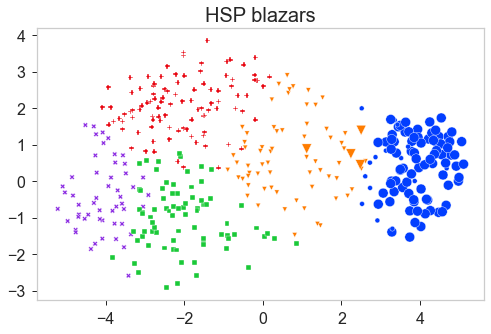

In [480]:
# HSP blazars
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16


tsne = TSNE(n_components=2, perplexity=150, init='pca',
            learning_rate='auto', random_state=42)
df_tsne = pd.DataFrame(tsne.fit_transform(X))
df_tsne['Cluster'] = bzcat_pca_dropna.reset_index()['cluster_kmeans']
df_tsne['size'] = bzcat_pca_dropna.reset_index()['is_HSP'].astype(int) * 6
df_tsne.loc[~bzcat_pca_dropna.reset_index()['is_HSP'], 'size'] = 1

plt.figure(figsize=(8, 5))
ax = sns.scatterplot(data=df_tsne, x=0, y=1, hue='Cluster', palette='bright',
                     size= 'size', 
                style='Cluster', markers=['o', 'v', 's', 'P', 'X'])
ax.tick_params(direction='out', length=5, width=1)
plt.grid(False)
ax.get_legend().remove()
ax.set_title('HSP blazars', fontsize=20)
plt.xlabel('', fontsize=14)
plt.ylabel('', fontsize=14)
plt.savefig('./figs/HSP.png', format='png')
plt.savefig('./figs/HSP.eps', format='eps')

Cross identification with the Roma-BZCAT classification. We should note that any consistency with this classification was not (and is not) a purpose of our clustering!

In [481]:
pd.crosstab(
    bzcat_pca_dropna['cluster_kmeans'], 
    bzcat_pca_dropna['Class'], margins=True)

Class,BLLac,BLLac_c,BZG,BZQ,BZU,All
cluster_kmeans,,,,,,
0,61,6,26,3,1,97
1,21,0,7,34,7,69
2,17,0,1,55,6,79
3,2,0,0,89,8,99
4,3,0,0,46,3,52
All,104,6,34,227,25,396


Distributions of the features used in the clustering (boxplots)

(<Figure size 1800x1404 with 24 Axes>,
 array([[<Axes: xlabel='Rad_opt_sp_index', ylabel='Cluster'>,
         <Axes: xlabel='comoving_distance_Mpc', ylabel='Cluster'>,
         <Axes: xlabel='tangent_wise', ylabel='Cluster'>,
         <Axes: xlabel='tangent_pstarrs', ylabel='Cluster'>],
        [<Axes: xlabel='log_nu_radmax', ylabel='Cluster'>,
         <Axes: xlabel='log_radio_luminosity', ylabel='Cluster'>,
         <Axes: xlabel='radio_IR', ylabel='Cluster'>,
         <Axes: xlabel='radio_UV', ylabel='Cluster'>],
        [<Axes: xlabel='radio_X', ylabel='Cluster'>,
         <Axes: xlabel='IR_opt', ylabel='Cluster'>,
         <Axes: xlabel='IR_UV', ylabel='Cluster'>,
         <Axes: xlabel='IR_X', ylabel='Cluster'>],
        [<Axes: xlabel='log_nuF_gamma', ylabel='Cluster'>,
         <Axes: xlabel='log_gamma_luminosity_ph', ylabel='Cluster'>,
         <Axes: xlabel='radio_gamma', ylabel='Cluster'>,
         <Axes: xlabel='IR_gamma', ylabel='Cluster'>],
        [<Axes: xlabel='opt_gam

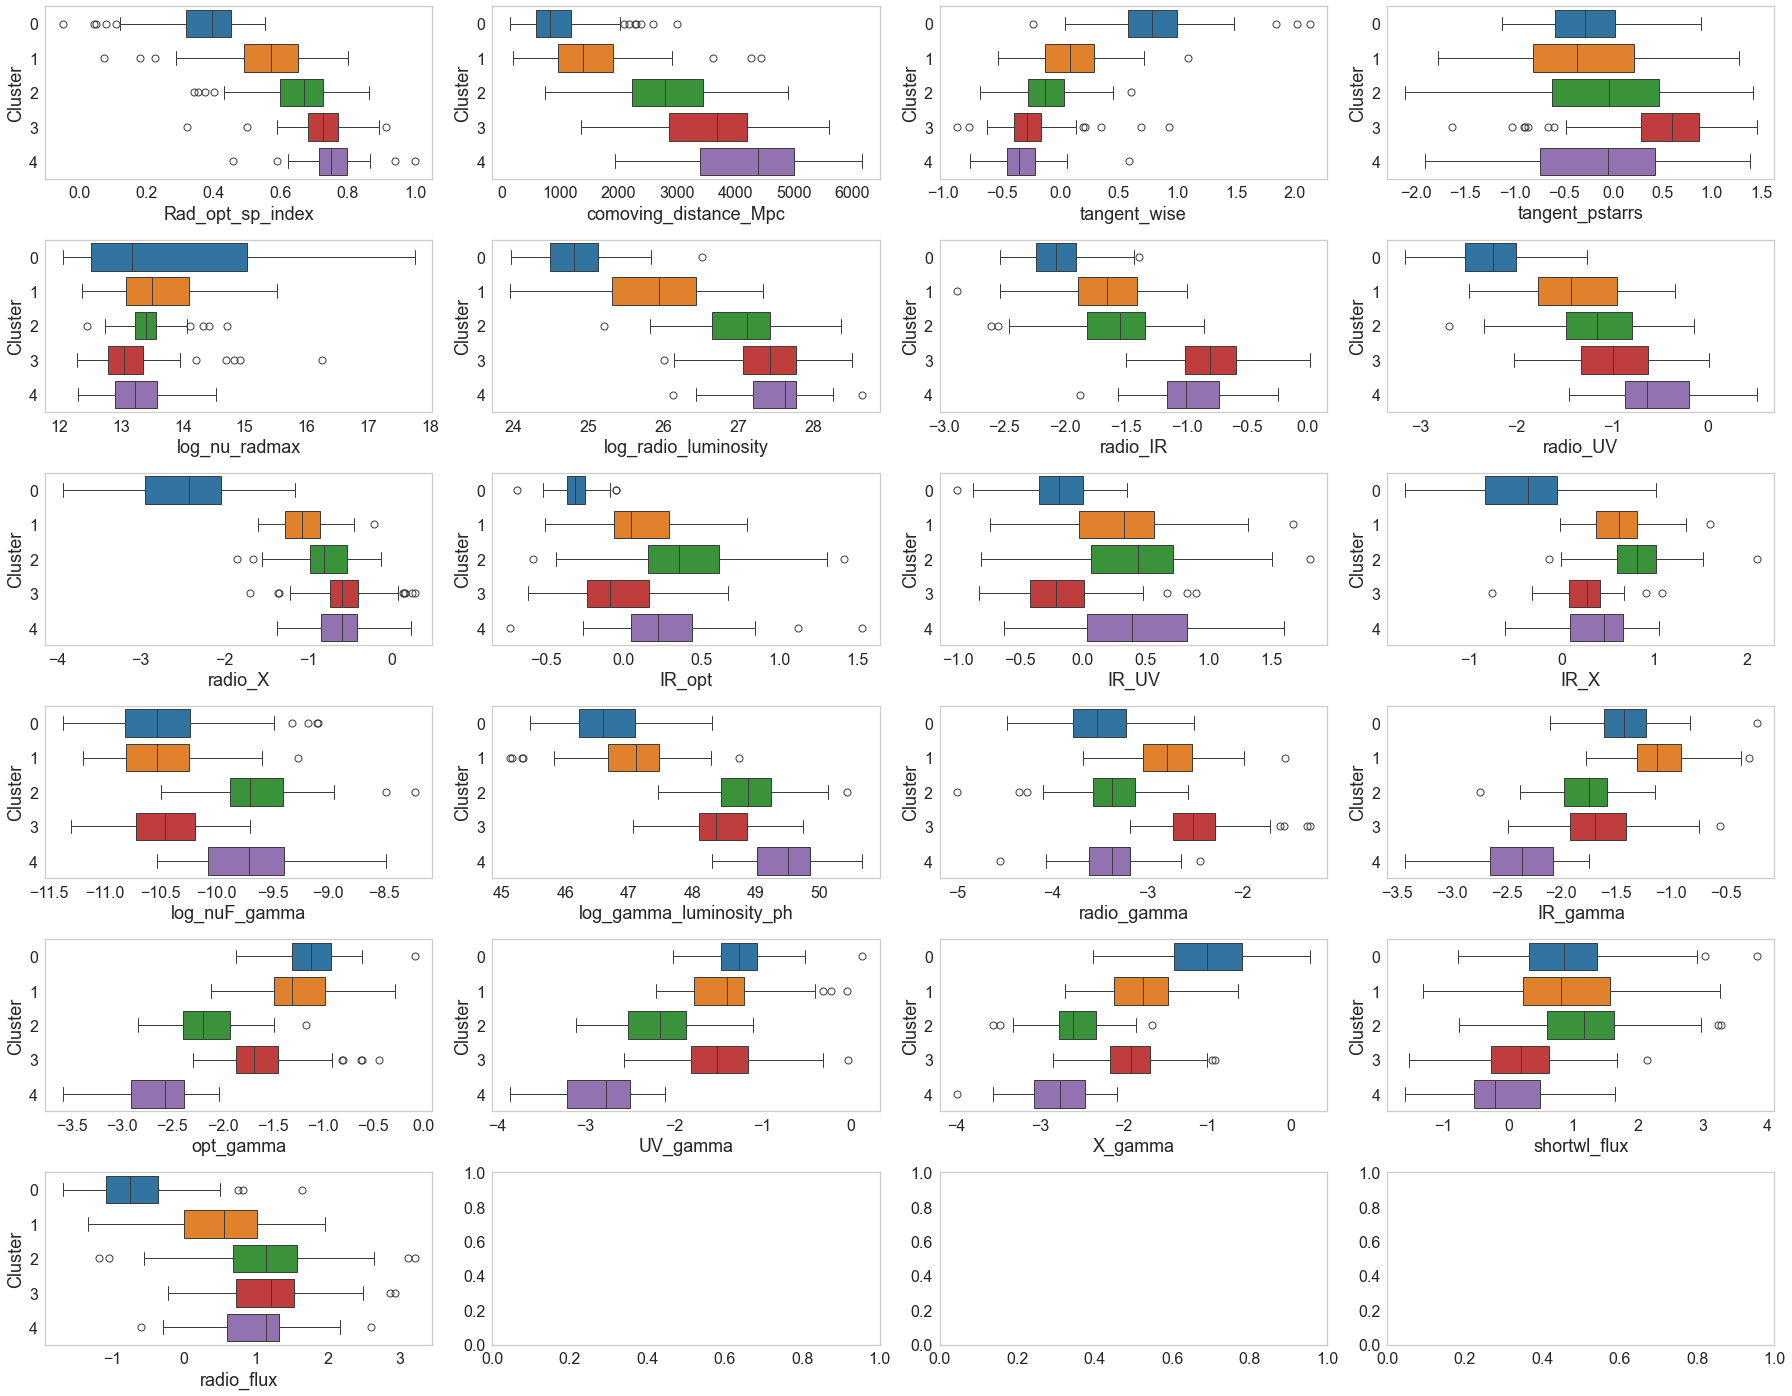

In [482]:
cols = model_df.columns #[:4]
plot_distr(bzcat_pca_dropna, cols, file='distr_nonan')

---

### 3.2. Original features for the small dataset

In [483]:
model_pca_dropna.columns

Index(['Rad_opt_sp_index', 'comoving_distance_Mpc', 'tangent_wise',
       'tangent_pstarrs', 'log_nu_radmax', 'log_radio_luminosity', 'radio_IR',
       'radio_UV', 'radio_X', 'IR_opt', 'IR_UV', 'IR_X', 'log_nuF_gamma',
       'log_gamma_luminosity_ph', 'radio_gamma', 'IR_gamma', 'opt_gamma',
       'UV_gamma', 'X_gamma', 'shortwl_flux', 'radio_flux'],
      dtype='object')

In [484]:
cols_to_drop = ['log_nuF_gamma', 'log_gamma_luminosity_ph', 'radio_gamma', 'IR_gamma', 'opt_gamma', 'UV_gamma', 'X_gamma']
model_orig_feat = model_pca_dropna.drop(cols_to_drop, axis=1).copy()
bzcat_orig_feat = bzcat_pca_dropna.copy()

bzcat_orig_feat.rename({'cluster_kmeans': 'cluster_gamma', 'cluster': 'cluster_orig'}, axis=1, inplace=True)

In [485]:
# pca
pca = PCA(n_components=0.9, random_state=42)
X = pca.fit_transform(model_orig_feat)
print(f'The number of principal components: {pca.n_components_}')

The number of principal components: 6


/home/dkudr/miniconda3/envs/bzcat/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Silhouette: 0.259
Davis-Bouldin: 1.316
Calinski-Harabatz: 171.438
Inertia: 1842.406
          0         1         2         3         4
0  0.000000  3.784689  3.915436  3.241059  3.893493
1  3.784689  0.000000  5.985176  2.907083  6.271199
2  3.915436  5.985176  0.000000  6.172038  3.305116
3  3.241059  2.907083  6.172038  0.000000  6.482099
4  3.893493  6.271199  3.305116  6.482099  0.000000


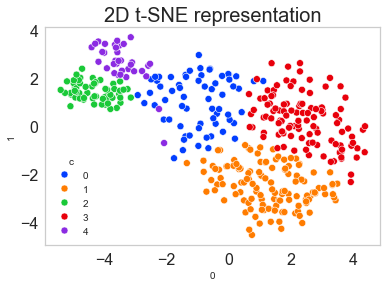

In [486]:
make_kmeans_clusters(X, bzcat_orig_feat, 5, 150)

In [487]:
# Between full dataset and small dataset with 14 features
metrics.rand_score(bzcat_orig_feat['cluster_kmeans'], bzcat_orig_feat['cluster_orig'])

0.8495460938498913

In [488]:
# Between small dataset with gamma featutes and small dataset with 14 features
metrics.rand_score(bzcat_orig_feat['cluster_kmeans'], bzcat_orig_feat['cluster_gamma'])

0.8037079657332822